In [2]:
!pip install opencv-python numba numpy matplotlib requests

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached numba-0.62.1-cp313-cp313-win_amd64.whl.metadata (2.9 kB)
  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached llvmlite-0.45.1-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl (12.6 MB)
Using cached numba-0.62.1-cp313-cp313-win_amd64.whl (2.7 MB)
Using cached llvmlite-0.45.1-cp313-cp313-win_amd64.whl (38.1 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.3.3

   ---------------------------------------- 0/4 [numpy]
    Uninstalling numpy-2.3.3:
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
      Successfully uninstalled numpy-2.3.3
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   -----------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# === IMPORTAR LIBRERÍAS ===
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import requests

In [3]:
# === CREAR CARPETA LOCAL ===
carpeta = "imagenes"
os.makedirs(carpeta, exist_ok=True)

In [23]:
# Descargar 250 imágenes desde picsum.photos (muy estable para pruebas)
import os, time, requests
from PIL import Image
from io import BytesIO

carpeta = r"C:\Users\jeyco\Documents\GitHub\FiltradoEspacio\images\imagenes"
os.makedirs(carpeta, exist_ok=True)

total = 250
headers = {"User-Agent": "Test-Agent"}



In [24]:
# === SELECCIONAR UNA IMAGEN ALEATORIA ===
imagenes = os.listdir(carpeta)
imagen_random = random.choice(imagenes)
ruta_imagen = os.path.join(carpeta, imagen_random)
print("🖼️ Imagen seleccionada:", ruta_imagen)

🖼️ Imagen seleccionada: C:\Users\jeyco\Documents\GitHub\FiltradoEspacio\images\imagenes\foto_100.jpg


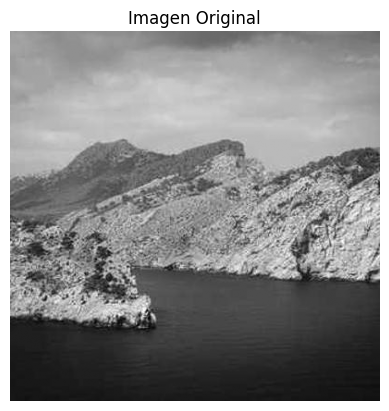

In [25]:
# === CARGAR IMAGEN EN ESCALA DE GRISES ===
img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")

# === MOSTRAR LA IMAGEN ===
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Imagen Original')
plt.show()

In [8]:
# === FILTRO PROMEDIO (Lineal) ===
@njit(parallel=True)
def filtro_promedio(img, ksize=3):
    filas, columnas = img.shape
    salida = np.zeros_like(img)
    offset = ksize // 2

    for i in prange(offset, filas - offset):
        for j in range(offset, columnas - offset):
            suma = 0
            for m in range(-offset, offset + 1):
                for n in range(-offset, offset + 1):
                    suma += img[i + m, j + n]
            salida[i, j] = suma // (ksize * ksize)
    return salida

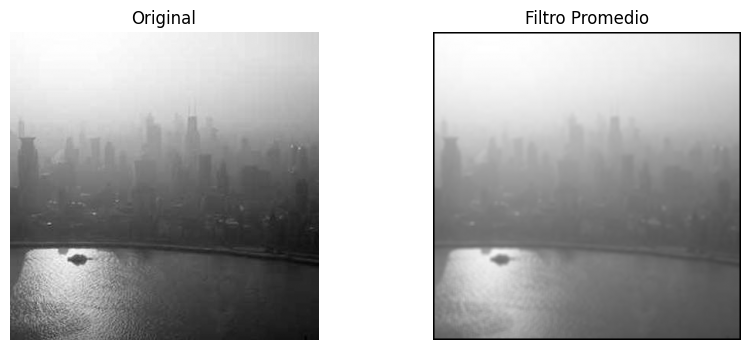

In [9]:
# === APLICAR FILTRO ===
prom = filtro_promedio(img, 5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(prom, cmap='gray'); plt.title('Filtro Promedio'); plt.axis('off')
plt.show()


FILTRADO NO LINEAL - MEDIANA

In [10]:
# === DEFINIR FILTRO DE MEDIANA (NO LINEAL) ===
@njit(parallel=True)
def filtro_mediana(img, ksize=3):
    filas, columnas = img.shape
    salida = np.zeros_like(img)
    offset = ksize // 2

    for i in prange(offset, filas - offset):
        for j in range(offset, columnas - offset):
            vecindad = []
            for m in range(-offset, offset + 1):
                for n in range(-offset, offset + 1):
                    vecindad.append(img[i + m, j + n])
            salida[i, j] = np.median(np.array(vecindad))
    return salida

⏳ Aplicando filtro de mediana...
✅ Filtro aplicado correctamente.


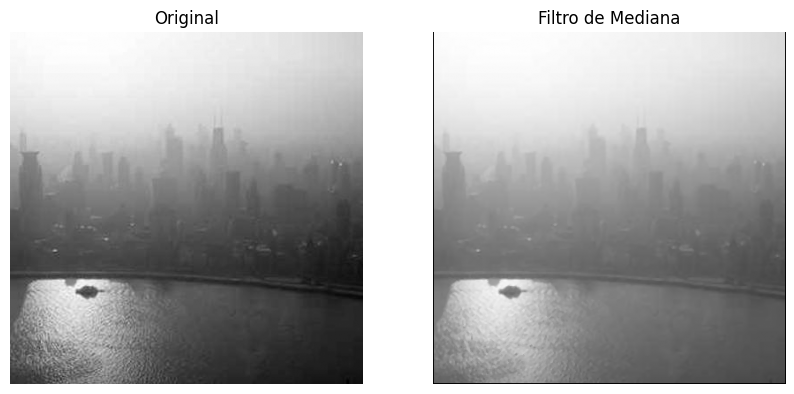

In [11]:
# === APLICAR EL FILTRO DE MEDIANA ===
print("⏳ Aplicando filtro de mediana...")
mediana = filtro_mediana(img, 3)
print("✅ Filtro aplicado correctamente.")

# === MOSTRAR RESULTADOS ===
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mediana, cmap='gray')
plt.title('Filtro de Mediana')
plt.axis('off')

plt.show()

FILTRADO ESPACIAL PASO ALTO - REALCE DE BORDES

In [14]:
# === DEFINICIÓN DE FUNCIONES ===
@njit(inline='always')
def clip_valor(x, minimo=0, maximo=255):
    """Evita que los valores del resultado se salgan del rango válido (0-255)."""
    if x < minimo:
        return minimo
    elif x > maximo:
        return maximo
    else:
        return x

@njit(parallel=True)
def filtro_paso_alto(img):
    """Filtro espacial de paso alto (detección de bordes)."""
    filas, columnas = img.shape
    salida = np.zeros_like(img, dtype=np.uint8)

    # Kernel de realce / detección de bordes
    kernel = np.array([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ], dtype=np.int32)

    offset = 1
    for i in prange(offset, filas - offset):
        for j in range(offset, columnas - offset):
            suma = 0
            for m in range(-offset, offset + 1):
                for n in range(-offset, offset + 1):
                    suma += img[i + m, j + n] * kernel[m + offset, n + offset]
            salida[i, j] = clip_valor(suma)
    return salida

⏳ Aplicando filtro paso alto...
✅ Filtro aplicado correctamente.


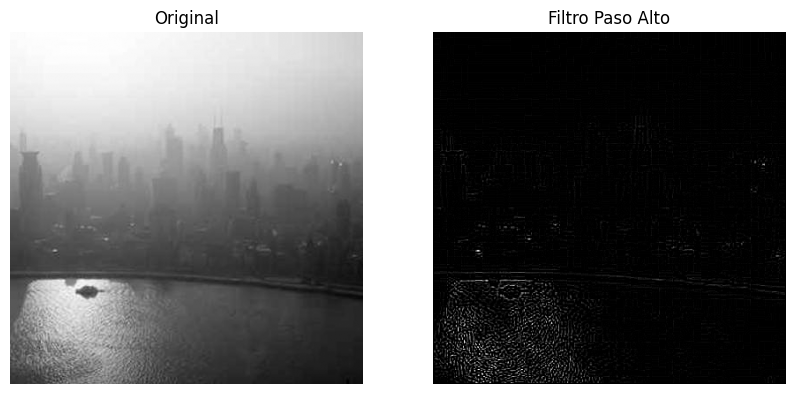

In [15]:
# === APLICAR FILTRO ===
print("⏳ Aplicando filtro paso alto...")
borde = filtro_paso_alto(img)
print("✅ Filtro aplicado correctamente.")

# === MOSTRAR RESULTADOS ===
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(borde, cmap='gray')
plt.title('Filtro Paso Alto')
plt.axis('off')
plt.show()